In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import time
import os 
os.chdir('./2-3/')
import tf_utils


np.random.seed(1)

In [2]:
a = tf.constant(2)
b = tf.constant(10)
c = a * b
print(f'c : {c}')
with tf.Session() as sess:
    c = sess.run(c)
print(f'c = {c}')

c : Tensor("mul:0", shape=(), dtype=int32)
c = 20


In [3]:
x = tf.placeholder(tf.float64, name='x')
with tf.Session() as sess:
    c = sess.run(2*x, feed_dict={x:3})
print(f'c = {c}')

c = 6.0


In [4]:
a = np.array([[1,2],[3,4]])
b = np.array([[1,2],[3,4]])
c = tf.matmul(a, b)   # 可以接受np.ndarray对象
with tf.Session() as sess:
    c = sess.run(c)
print(type(c))
print(c)

<class 'numpy.ndarray'>
[[ 7 10]
 [15 22]]


In [5]:
s = tf.sigmoid(c.astype(np.float64))   
# 可以接受np.ndarray对象, 但接受类型有限, 要注意转化类型
s1 = tf.sigmoid(tf.constant(a, dtype=tf.float64)) 
with tf.Session() as sess:
    print(sess.run(s)) 
    print(sess.run(s1))

[[0.99908895 0.9999546 ]
 [0.99999969 1.        ]]
[[0.73105858 0.88079708]
 [0.95257413 0.98201379]]


In [6]:
sess = tf.Session()
one = tf.ones((3,3))
zero = tf.zeros((3,3))
y = np.array([[1,2,3,0,3,4,2,1,1]])
c = 5
one_hot_matrix = tf.one_hot(indices=np.squeeze(y), depth=c, axis=0) 
# 参数可以是tensor对象, 可以是np.ndarray/int...python对象
# 返回对象会增加一个维度, 所以或者压缩y的维度, 或者reshape
print(f'one\n{sess.run(one)}')
print(f'one\n{sess.run(zero)}')
print(f'one_hot_matrix\n{sess.run(one_hot_matrix)}')

one
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
one
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
one_hot_matrix
[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [7]:
X_train, Y_train, X_test, Y_test, classes =tf_utils.load_dataset()

In [8]:
print(f'X_train.shape = {X_train.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_test.shape = {Y_test.shape}')
print(f'classes.shape = {classes.shape}')
print(f'classes = {classes}')

X_train.shape = (1080, 64, 64, 3)
Y_train.shape = (1, 1080)
X_test.shape = (120, 64, 64, 3)
Y_test.shape = (1, 120)
classes.shape = (6,)
classes = [0 1 2 3 4 5]


Y = 1


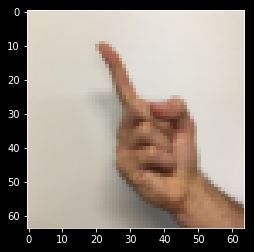

In [9]:
print(f'Y = {Y_train[0,11]}')
plt.imshow(X_train[11])

In [10]:
C = 6
X_train = X_train.reshape((X_train.shape[0], -1)).T / 255
Y_train = tf_utils.convert_to_one_hot(Y_train, C)
X_test = X_test.reshape((X_test.shape[0], -1)).T / 255
Y_test = tf_utils.convert_to_one_hot(Y_test, C)

In [11]:
print(f'X_train.shape = {X_train.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (12288, 1080)
Y_train.shape = (6, 1080)
X_test.shape = (12288, 120)
Y_test.shape = (6, 120)


In [12]:
def model_with_tf(X, Y, alpha=0.001, loops=10000):

    n_x = X.shape[0]
    n_y = Y.shape[0]

    # ======------start build compute graph------======

    # set placeholder for mini-batch
    x = tf.placeholder(tf.float64, [n_x, None], name='X')
    y = tf.placeholder(tf.float64, [n_y, None], name='Y')

    # initial weights
    # get_variable返回name匹配的tensor, 没有匹配的则创建新的变量, 方便后续返回参数
    W1 = tf.get_variable('W1', [25, n_x], dtype=tf.float64, initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [25, 1], dtype=tf.float64, initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [12, 25], dtype=tf.float64, initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [12, 1], dtype=tf.float64, initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', [6, 12], dtype=tf.float64, initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [6, 1], dtype=tf.float64, initializer=tf.zeros_initializer())

    # forwardprop
    z1 = tf.matmul(W1, x) + b1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(W2, a1) + b2
    a2 = tf.nn.relu(z2)
    z3 = tf.matmul(W3, a2) + b3
    # tf.nn.softmax_cross_entropy_with_logits接受的是线性输出z3, softmax将在函数内部完成

    # compute cost
    # tf.nn.softmax_cross_entropy_with_logits接受的是(m_batches, n_features)shape参数
    logits = tf.transpose(z3)
    labels = tf.transpose(y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    # use optimizer to backprop and update parameters
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
    # initialize all variables
    init = tf.global_variables_initializer()

    # ======------finish build compute graph------======


    # ======------start training------======
    
    sess = tf.Session()
    sess.run(init)
    seed = 0
    J_list = []
    for i in range(loops):
        seed += 1
        # segment train set to mini-batches
        mini_batches = tf_utils.random_mini_batches(X, Y, mini_batch_size=64, seed=seed)
        for batch in mini_batches:
            X_mini, Y_mini = batch
            _, J = sess.run([optimizer, cost], feed_dict={x: X_mini, y: Y_mini})
        if i == 0:
            print(f'No.{i+1} iteration\'s loss: {J}')
        if (i+1) % 10 == 0:
            J_list.append(J)
        if (i+1) % 100 == 0:
            print(f'No.{i+1} iteration\'s loss: {J}')
    
    # ======------finish training------======

    # plot loss circle
    plt.plot(J_list)
    plt.title('loss circle')
    plt.xlabel('# epoch per 10')
    plt.ylabel('loss')
    plt.show()

    # ======------return parameters------======

    params = {
        'W1': sess.run(W1),
        'b1': sess.run(b1),
        'W2': sess.run(W2),
        'b2': sess.run(b2),
        'W3': sess.run(W3),
        'b3': sess.run(b3)
    }

    sess.close()

    return params


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

No.1 iteration's loss: 1.7778395032453187
No.100 iteration's loss: 0.8621898132457032
No.200 iteration's loss: 0.7854398838458148
No.300 iteration's loss: 0.473530520328687
No.400 iteration's loss: 0.41046037535172536
No.500 iteration's loss: 0.3755059737689314
No.600 iteration's loss: 0.32931211208799904
No.700 iteration's loss: 0.17417996560777055
No.800 iteration's loss: 0.17284609431082001
No.900 iteration's loss: 0.13461299927750997
No.

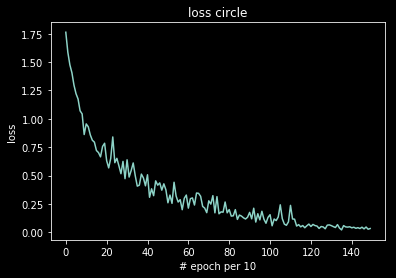

In [13]:
params = model_with_tf(X_train, Y_train, alpha=0.0001, loops=1500)

In [22]:
# 本案例中在模型中把类型全部定成float32更好, 因为tf_utils.py里面用的是float32
# 这里因为不想重新训练所以直接把后面的代码搬过来改了...其实可以直接调用
params['W1'] = params['W1'].astype(np.float32)
params['b1'] = params['b1'].astype(np.float32)
params['W2'] = params['W2'].astype(np.float32)
params['b2'] = params['b2'].astype(np.float32)
params['W3'] = params['W3'].astype(np.float32)
params['b3'] = params['b3'].astype(np.float32)

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder('float', [12288, None])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
# ======------如果模型内类型用的是float32, 那以上都是废话------======



Y_predict = predict(X_test, params)
Y_ = np.argmax(Y_test, axis=0)  # Y_test前面不该转one-hot
accuracy = np.mean(Y_predict == Y_)
print(f'accuracy = {accuracy}')

# 计算测试集准确率, 很多废话, 纯属偷懒...

accuracy = 0.8166666666666667


预测1:
预测结果: 第1张 = 1
预测2:
预测结果: 第2张 = 1
预测3:
预测结果: 第3张 = 4
预测4:
预测结果: 第4张 = 2
预测5:
预测结果: 第5张 = 5


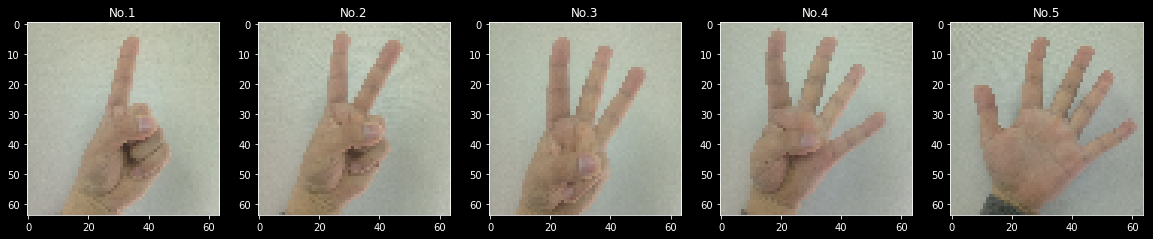

In [27]:
from matplotlib.image import imread

plt.rcParams['figure.figsize'] = (20.0, 4.0)

for i in range(1,6):
    print(f'预测{i}:')
    fileName = f"./datasets/fingers/{i}.png"
    image = imread(fileName)
    plt.subplot(1,5,i)
    plt.title(f'No.{i}')
    plt.imshow(image)
    my_image = image.reshape(-1, 1)
    my_image_prediction = predict(my_image, params)
    print(f'预测结果: 第{i}张 = {np.squeeze(my_image_prediction)}')


## 测试集准确率达到81.7% , 然而5张实拍图只对2张